# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version = '12'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="graupel"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                   (cell: 2684736)
Dimensions without coordinates: cell
Data variables: (12/97)
    time                      (cell) float32 ...
    q_cloud                   (cell) float32 ...
    n_cloud                   (cell) float32 ...
    q_rain                    (cell) float32 ...
    n_rain                    (cell) float32 ...
    q_ice                     (cell) float32 ...
    ...                        ...
    frze_graupel_rain_mass    (cell) float32 ...
    frze_graupel_rain_rmass   (cell) float32 ...
    frze_graupel_rain_rvol    (cell) float32 ...
    frze_graupel_rain_liq     (cell) float32 ...
    rime_graupel_rain_num     (cell) float32 ...
    rime_graupel_rain_mass    (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     So  5 Jun 2022 13:37:07 CEST
    nfiles:   18051


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_g  = xr.open_dataset(fname).q_graupel.values
    num_g  = xr.open_dataset(fname).n_graupel.values
    rime_g = xr.open_dataset(fname).rime_graupel.values
    rvol_g = xr.open_dataset(fname).rvol_graupel.values
    liq_g  = xr.open_dataset(fname).liq_graupel.values
    # process rates
    melt_num   = xr.open_dataset(fname).melt_graupel_rain_num.values 
#    melt_liq   = xr.open_dataset(fname).melt_graupel_rain_liq.values   
    melt_mass  = xr.open_dataset(fname).melt_graupel_rain_mass.values   
#    melt_rmass = xr.open_dataset(fname).melt_graupel_rain_rmass.values
#    melt_rvol  = xr.open_dataset(fname).melt_graupel_rain_rvol.values
    # rescale process rate with temperature 
    t_3 = 273.15
    melt_num  = np.where(temp > t_3, melt_num, np.nan)
    melt_mass = np.where(temp > t_3, melt_mass, np.nan)
    # some numerical lower bounds
    q_min = 1e-15
    n_min = 1e-15
    z_min = 1e-20
    p_min = 1e-20
    # use liquid water fraction (no log transform for this)
    liq_g = np.where(q_g>q_min,liq_g/q_g,np.nan)      
    # transform everything in log space
    q_g = np.log(q_g, where=q_g>q_min)
    num_g  = np.log(num_g, where=num_g>n_min)
    rime_g = np.log(rime_g, where=rime_g>q_min)
    rvol_g = np.log(rvol_g, where=rvol_g>q_min)
    melt_num   = np.log(melt_num,  where=melt_num>p_min,  out=np.nan*melt_num)
    melt_mass  = np.log(melt_mass, where=melt_mass>p_min, out=np.nan*melt_mass)
#    melt_liq   = np.log(melt_liq,  where=melt_liq>p_min,  out=np.nan*melt_liq)
#    melt_rmass = np.log(melt_rmass,where=melt_rmass>p_min,out=np.nan*melt_rmass)
#    melt_rvol  = np.log(melt_rvol, where=melt_rvol>p_min, out=np.nan*melt_rvol)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_g, num_g, rime_g, rvol_g, liq_g, temp, melt_mass, melt_num ]))
    dataset = dataset.T
    dataset.columns = [ 'q_g', 'num_g', 'rime_g', 'rvol_g', 'liq_g', 'temp', 'melt_mass', 'melt_num' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater


In [8]:
df.describe()

q_g          num_g         rime_g        rvol_g  \
count  446066.000000  446066.000000  446066.000000  4.460660e+05   
mean       -6.544309       3.660935      -7.266502 -1.382143e+01   
std         2.610414       2.854776       3.043712  3.078120e+00   
min       -23.017883     -14.498609     -31.441120 -3.451789e+01   
25%        -7.308005       2.296336      -8.274325 -1.492114e+01   
50%        -5.794944       4.173926      -6.470178 -1.296639e+01   
75%        -4.841465       5.549115      -5.212805 -1.172120e+01   
max        -3.506591      10.301122      -3.517282  8.468001e-13   

               liq_g           temp      melt_mass       melt_num  
count  446066.000000  446066.000000  446066.000000  446066.000000  
mean        0.415899     277.523224     -14.944939      -2.087192  
std         0.268851       3.678372       3.665595       3.547638  
min         0.000585     273.170013     -38.155457     -31.194771  
25%         0.177493     274.760010     -17.034618      -3.924690  
50%         0.379049     276.480011     -14.181736      -1.603411  
75%         0.635957     279.220001     -12.111774       0.362906  
max         1.000000     297.190002      -8.184894       7.260438

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_g     num_g     rime_g     rvol_g     liq_g        temp  \
127 -13.802693  1.678852 -14.516065 -20.593203  0.488518  273.959991   
130 -13.821730  1.606313 -14.678473 -20.764650  0.556903  274.040009   
131 -13.829833  1.571217 -14.738625 -20.827871  0.579409  274.070007   
134 -13.851615  1.517871 -14.959361 -21.058332  0.655401  274.160004   
140 -14.007132  1.225597 -15.597518 -21.718166  0.787541  274.339996   

     melt_mass  melt_num  
127 -18.698038 -1.961658  
130 -18.892849 -2.454135  
131 -19.027105 -2.772589  
134 -17.085640 -1.067841  
140 -16.308294 -0.662376

In [11]:
dataset_train.describe()

q_g          num_g         rime_g        rvol_g  \
count  312239.000000  312239.000000  312239.000000  3.122390e+05   
mean       -6.545132       3.659890      -7.267271 -1.382313e+01   
std         2.610218       2.854815       3.044492  3.079416e+00   
min       -23.017883     -14.403416     -31.441120 -3.451789e+01   
25%        -7.311379       2.297527      -8.275640 -1.492113e+01   
50%        -5.796819       4.174526      -6.471567 -1.296840e+01   
75%        -4.842406       5.546349      -5.214509 -1.172238e+01   
max        -3.506591      10.301122      -3.520961  7.292100e-13   

               liq_g           temp      melt_mass       melt_num  
count  312239.000000  312239.000000  312239.000000  312239.000000  
mean        0.415827     277.520874     -14.949109      -2.089956  
std         0.268868       3.674975       3.668664       3.547996  
min         0.002164     273.170013     -37.668316     -31.194771  
25%         0.177451     274.760010     -17.035559      -3.922035  
50%         0.378872     276.480011     -14.185772      -1.603615  
75%         0.635891     279.220001     -12.112984       0.362871  
max         1.000000     297.190002      -8.190991       7.259201

In [12]:
dataset_test.describe()

q_g         num_g        rime_g        rvol_g         liq_g  \
count  66826.000000  66826.000000  66826.000000  6.682600e+04  66826.000000   
mean      -6.546771      3.672833     -7.270556 -1.382386e+01      0.416574   
std        2.604949      2.845530      3.035238  3.069588e+00      0.268848   
min      -23.014614    -14.498609    -31.033640 -3.402362e+01      0.002526   
25%       -7.306235      2.303784     -8.280906 -1.493306e+01      0.177844   
50%       -5.798137      4.177904     -6.475583 -1.297267e+01      0.380828   
75%       -4.846665      5.557281     -5.219557 -1.173078e+01      0.636397   
max       -3.506658      9.977110     -3.517282  5.099600e-13      0.999882   

               temp     melt_mass      melt_num  
count  66826.000000  66826.000000  66826.000000  
mean     277.527252    -14.926090     -2.064372  
std        3.689864      3.650166      3.532763  
min      273.190002    -37.119213    -15.191755  
25%      274.750000    -17.031751     -3.921189  
50%      276.470001    -14.162899     -1.599411  
75%      279.220001    -12.107676      0.374478  
max      296.440002     -8.184894      7.093720

In [13]:
dataset_val.describe()

q_g         num_g        rime_g        rvol_g         liq_g  \
count  67001.000000  67001.000000  67001.000000  6.700100e+04  67001.000000   
mean      -6.538010      3.653941     -7.258867 -1.381106e+01      0.415562   
std        2.616796      2.863793      3.048547  3.080599e+00      0.268777   
min      -22.870045    -14.403416    -31.080160 -3.384718e+01      0.000585   
25%       -7.291816      2.283168     -8.261543 -1.490821e+01      0.177342   
50%       -5.780491      4.167301     -6.459358 -1.294946e+01      0.377988   
75%       -4.830566      5.553851     -5.198110 -1.170461e+01      0.635806   
max       -3.506825     10.193916     -3.529520  8.468001e-13      0.999799   

               temp     melt_mass      melt_num  
count  67001.000000  67001.000000  67001.000000  
mean     277.530609    -14.944313     -2.097069  
std        3.682755      3.666635      3.560715  
min      273.200012    -38.155457    -15.191755  
25%      274.760010    -17.029531     -3.935138  
50%      276.480011    -14.182888     -1.599027  
75%      279.209991    -12.109886      0.360035  
max      296.970001     -8.282872      7.260438

### Reduce data

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_g'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['rvol_g'] > -1 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_g          num_g         rime_g         rvol_g  \
count  311931.000000  311931.000000  311931.000000  311931.000000   
mean       -6.530702       3.673671      -7.250529     -13.809156   
std         2.570604       2.821045       2.998112       3.036942   
min       -19.991619     -12.706849     -27.662100     -34.477680   
25%        -7.305706       2.304134      -8.267641     -14.912934   
50%        -5.794353       4.177444      -6.468533     -12.965916   
75%        -4.841614       5.547772      -5.213480     -11.721648   
max        -3.506591      10.301122      -3.520961      -9.004709   

               liq_g           temp      melt_mass       melt_num  
count  311931.000000  311931.000000  311931.000000  311931.000000  
mean        0.415388     277.520569     -14.939188      -2.079586  
std         0.268583       3.675734       3.656033       3.533464  
min         0.002164     273.170013     -37.668316     -31.194771  
25%         0.177292     274.760010     -17.025373      -3.907827  
50%         0.378399     276.470001     -14.180591      -1.598078  
75%         0.635175     279.220001     -12.111075       0.363455  
max         1.000000     297.190002      -8.190991       7.259201

In [17]:
dataset_test.describe()

q_g         num_g        rime_g        rvol_g         liq_g  \
count  66764.000000  66764.000000  66764.000000  66764.000000  66764.000000   
mean      -6.533074      3.685495     -7.254591    -13.811618      0.416174   
std        2.566936      2.814920      2.990051      3.030011      0.268589   
min      -19.988642    -13.112314    -26.934729    -33.679691      0.002526   
25%       -7.301580      2.310950     -8.272944    -14.926722      0.177713   
50%       -5.796967      4.180071     -6.472861    -12.970158      0.380338   
75%       -4.846124      5.558757     -5.218508    -11.730134      0.635771   
max       -3.506658      9.977110     -3.517282     -9.035547      0.999882   

               temp     melt_mass      melt_num  
count  66764.000000  66764.000000  66764.000000  
mean     277.527252    -14.916667     -2.055070  
std        3.690452      3.637841      3.520350  
min      273.190002    -37.119213    -15.191755  
25%      274.747498    -17.020417     -3.910019  
50%      276.470001    -14.159973     -1.595015  
75%      279.220001    -12.106322      0.376404  
max      296.440002     -8.184894      7.093720

### Pairplot

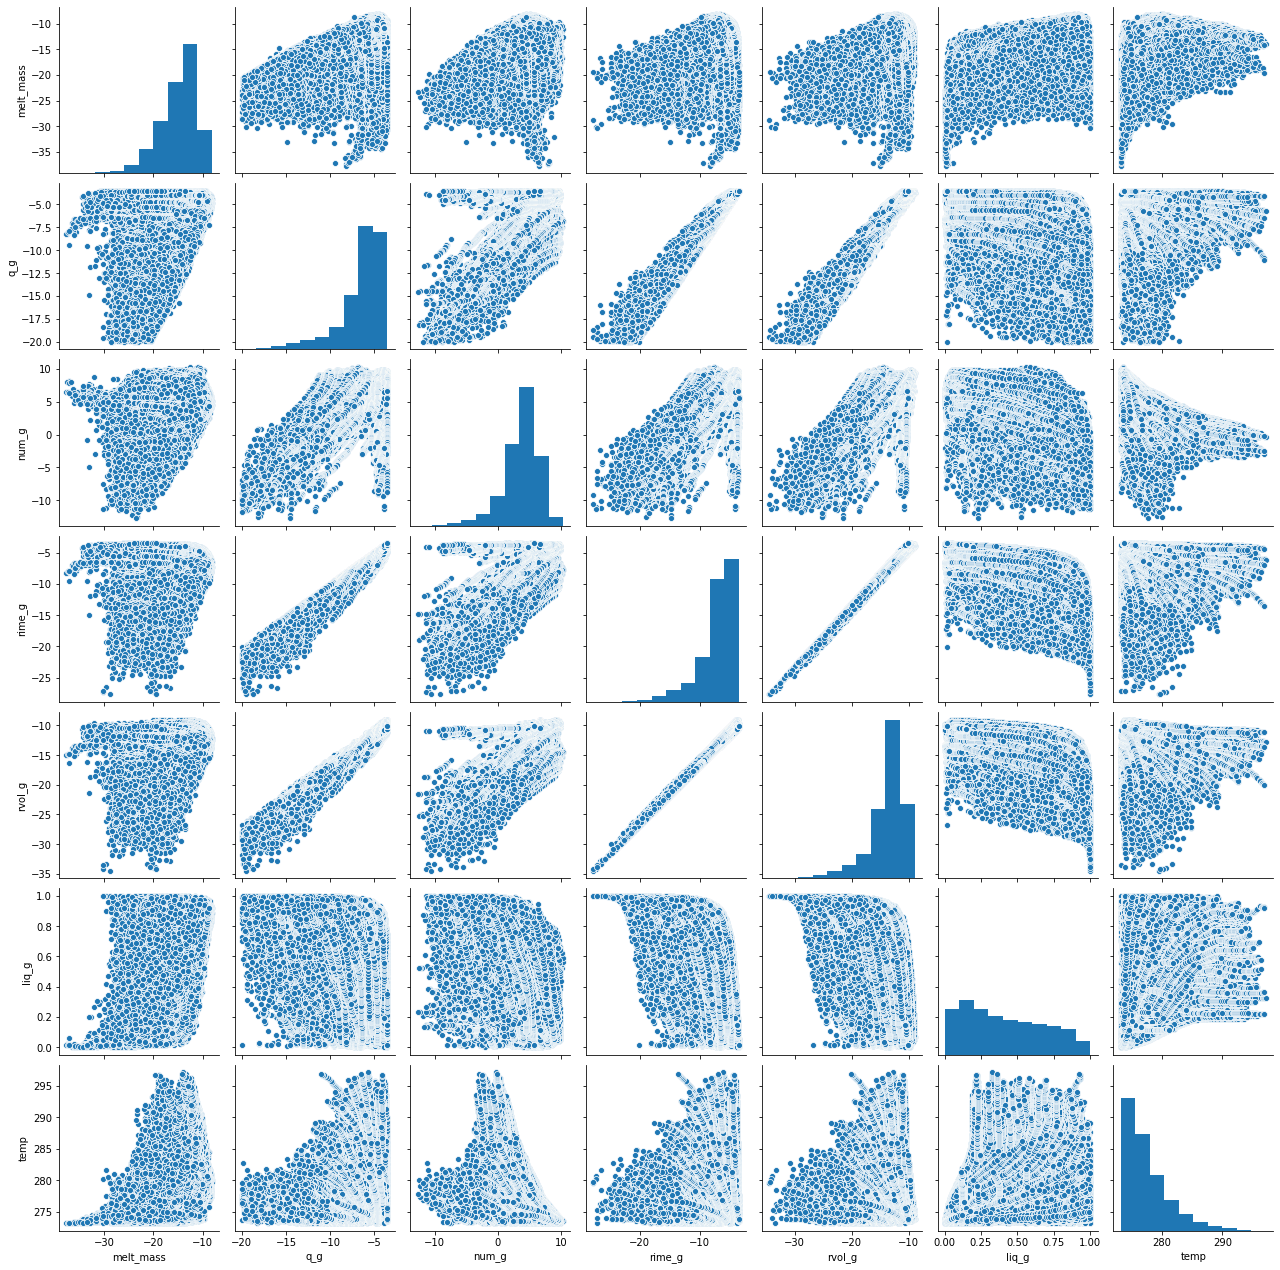

In [18]:
sns.pairplot(dataset_train[["melt_mass","q_g","num_g","rime_g","rvol_g","liq_g","temp"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [22]:
#train_dataset1 = train_dataset1.drop(['temp'], axis=1)
#train_dataset2 = train_dataset2.drop(['rho'], axis=1)
#train_dataset3 = train_dataset3.drop(['rho'], axis=1)

In [23]:
#test_dataset1 = test_dataset1.drop(['temp'], axis=1)
#test_dataset2 = test_dataset2.drop(['rho'], axis=1)
#test_dataset3 = test_dataset3.drop(['rho'], axis=1)

In [24]:
#val_dataset1 = val_dataset1.drop(['temp'], axis=1)
#val_dataset2 = val_dataset2.drop(['rho'], axis=1)
#val_dataset3 = val_dataset3.drop(['rho'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("melt_mass")
train_stats1.pop("melt_num")
train_stats1 = train_stats1.transpose()
train_stats1

count        mean       std         min         25%         50%  \
q_g     311931.0   -6.530702  2.570604  -19.991619   -7.305706   -5.794353   
num_g   311931.0    3.673671  2.821045  -12.706849    2.304134    4.177444   
rime_g  311931.0   -7.250529  2.998112  -27.662100   -8.267641   -6.468533   
rvol_g  311931.0  -13.809156  3.036942  -34.477680  -14.912934  -12.965916   
liq_g   311931.0    0.415388  0.268583    0.002164    0.177292    0.378399   
temp    311931.0  277.520569  3.675734  273.170013  274.760010  276.470001   

               75%         max  
q_g      -4.841614   -3.506591  
num_g     5.547772   10.301122  
rime_g   -5.213480   -3.520961  
rvol_g  -11.721648   -9.004709  
liq_g     0.635175    1.000000  
temp    279.220001  297.190002

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("melt_mass")
train_stats2.pop("melt_num")
train_stats2 = train_stats2.transpose()
train_stats2

count        mean       std         min         25%         50%  \
q_g     311931.0   -6.530702  2.570604  -19.991619   -7.305706   -5.794353   
num_g   311931.0    3.673671  2.821045  -12.706849    2.304134    4.177444   
rime_g  311931.0   -7.250529  2.998112  -27.662100   -8.267641   -6.468533   
rvol_g  311931.0  -13.809156  3.036942  -34.477680  -14.912934  -12.965916   
liq_g   311931.0    0.415388  0.268583    0.002164    0.177292    0.378399   
temp    311931.0  277.520569  3.675734  273.170013  274.760010  276.470001   

               75%         max  
q_g      -4.841614   -3.506591  
num_g     5.547772   10.301122  
rime_g   -5.213480   -3.520961  
rvol_g  -11.721648   -9.004709  
liq_g     0.635175    1.000000  
temp    279.220001  297.190002

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [27]:
# pop does not work for multiple columns, use copy instead

labels = ['melt_mass','melt_num']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [28]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [29]:
train_labels.describe()

melt_mass       melt_num
count  311931.000000  311931.000000
mean      -14.939188      -2.079586
std         3.656033       3.533464
min       -37.668316     -31.194771
25%       -17.025373      -3.907827
50%       -14.180591      -1.598078
75%       -12.111075       0.363455
max        -8.190991       7.259201

In [30]:
train_dataset1.describe()

q_g          num_g         rime_g         rvol_g  \
count  311931.000000  311931.000000  311931.000000  311931.000000   
mean       -6.530702       3.673671      -7.250529     -13.809156   
std         2.570604       2.821045       2.998112       3.036942   
min       -19.991619     -12.706849     -27.662100     -34.477680   
25%        -7.305706       2.304134      -8.267641     -14.912934   
50%        -5.794353       4.177444      -6.468533     -12.965916   
75%        -4.841614       5.547772      -5.213480     -11.721648   
max        -3.506591      10.301122      -3.520961      -9.004709   

               liq_g           temp  
count  311931.000000  311931.000000  
mean        0.415388     277.520569  
std         0.268583       3.675734  
min         0.002164     273.170013  
25%         0.177292     274.760010  
50%         0.378399     276.470001  
75%         0.635175     279.220001  
max         1.000000     297.190002

In [31]:
train_dataset2.describe()

q_g          num_g         rime_g         rvol_g  \
count  311931.000000  311931.000000  311931.000000  311931.000000   
mean       -6.530702       3.673671      -7.250529     -13.809156   
std         2.570604       2.821045       2.998112       3.036942   
min       -19.991619     -12.706849     -27.662100     -34.477680   
25%        -7.305706       2.304134      -8.267641     -14.912934   
50%        -5.794353       4.177444      -6.468533     -12.965916   
75%        -4.841614       5.547772      -5.213480     -11.721648   
max        -3.506591      10.301122      -3.520961      -9.004709   

               liq_g           temp  
count  311931.000000  311931.000000  
mean        0.415388     277.520569  
std         0.268583       3.675734  
min         0.002164     273.170013  
25%         0.177292     274.760010  
50%         0.378399     276.470001  
75%         0.635175     279.220001  
max         1.000000     297.190002

### Normalize the features

In [32]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)

In [33]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
q_g     311931.0 -4.300925e-08  1.0 -5.236481 -0.301487  0.286450  0.657078   
num_g   311931.0 -1.574555e-07  1.0 -5.806544 -0.485472  0.178577  0.664329   
rime_g  311931.0  1.092994e-08  1.0 -6.808142 -0.339251  0.260829  0.679444   
rvol_g  311931.0  3.664409e-07  1.0 -6.805701 -0.363450  0.277661  0.687372   
liq_g   311931.0  7.633443e-09  1.0 -1.538535 -0.886489 -0.137719  0.818316   
temp    311931.0  1.250239e-05  1.0 -1.183588 -0.751023 -0.285812  0.462338   

             max  
q_g     1.176421  
num_g   2.349290  
rime_g  1.243972  
rvol_g  1.582001  
liq_g   2.176649  
temp    5.351159

In [34]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
q_g     311931.0 -4.300925e-08  1.0 -5.236481 -0.301487  0.286450  0.657078   
num_g   311931.0 -1.574555e-07  1.0 -5.806544 -0.485472  0.178577  0.664329   
rime_g  311931.0  1.092994e-08  1.0 -6.808142 -0.339251  0.260829  0.679444   
rvol_g  311931.0  3.664409e-07  1.0 -6.805701 -0.363450  0.277661  0.687372   
liq_g   311931.0  7.633443e-09  1.0 -1.538535 -0.886489 -0.137719  0.818316   
temp    311931.0  1.250239e-05  1.0 -1.183588 -0.751023 -0.285812  0.462338   

             max  
q_g     1.176421  
num_g   2.349290  
rime_g  1.243972  
rvol_g  1.582001  
liq_g   2.176649  
temp    5.351159

### Normalize the labels

In [35]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean       std        min        25%        50%  \
melt_mass  311931.0 -14.939188  3.656033 -37.668316 -17.025373 -14.180591   
melt_num   311931.0  -2.079586  3.533464 -31.194771  -3.907827  -1.598078   

                 75%       max  
melt_mass -12.111075 -8.190991  
melt_num    0.363455  7.259201

In [36]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [37]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [38]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(6,16,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                112       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 690
Trainable params: 690
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [40]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.30472502, -0.8500776 ],
       [-0.3046983 , -0.8504456 ],
       [-0.3046872 , -0.8505557 ],
       [-0.3046587 , -0.8509523 ],
       [-0.30468827, -0.8515182 ],
       [-0.30488104, -0.8515228 ],
       [-0.30496085, -0.85155386],
       [-0.30531022, -0.851728  ],
       [-0.30582127, -0.85171044],
       [-0.30112424, -0.8477657 ]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [41]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [42]:
model2 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.2062,  mae:0.2719,  mse:0.2062,  val_loss:0.1446,  val_mae:0.2218,  val_mse:0.1446,  
.................................................................................................

Text(0, 0.5, 'MAE')

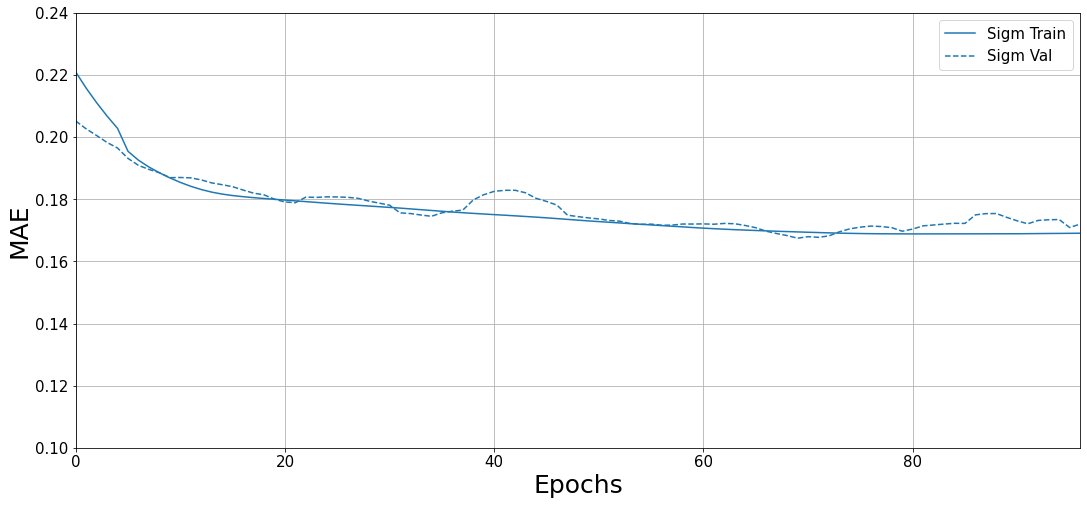

In [44]:
histories['sigm'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.24])
plt.ylabel('MAE')

In [45]:
activ = "ReLU"
model3 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1291,  mae:0.2053,  mse:0.1291,  val_loss:0.1135,  val_mae:0.1827,  val_mse:0.1135,  
......................................................................

Text(0, 0.5, 'MAE')

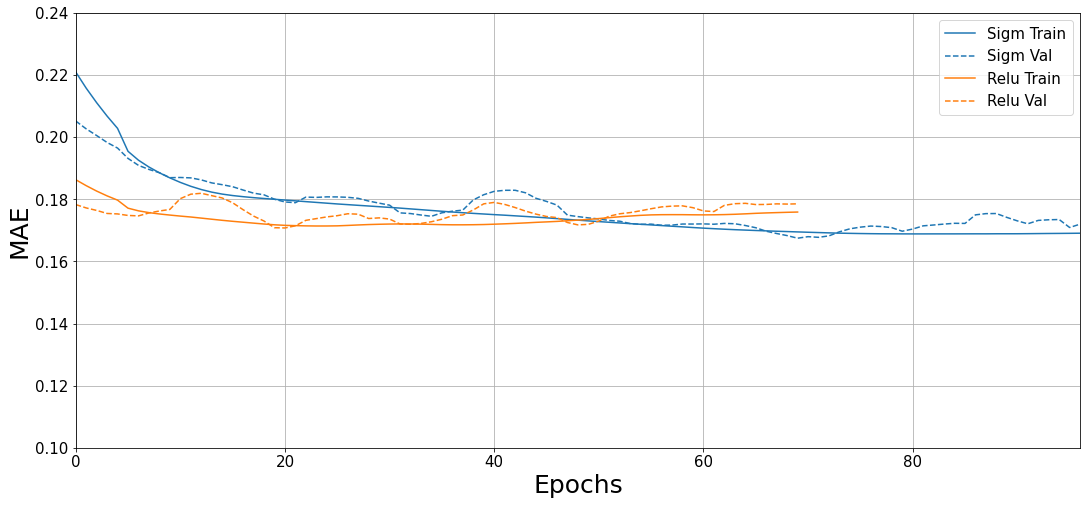

In [46]:
histories['ReLU'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.24])
plt.ylabel('MAE')

In [47]:
activ = "ReLU_Adam"
model4 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1216,  mae:0.1981,  mse:0.1216,  val_loss:0.1144,  val_mae:0.1839,  val_mse:0.1144,  
....................................................................................................
Epoch: 100, loss:0.0923,  mae:0.1630,  mse:0.0923,  val_loss:0.0934,  val_mae:0.1615,  val_mse:0.0934,  
.................................................

Text(0, 0.5, 'MAE')

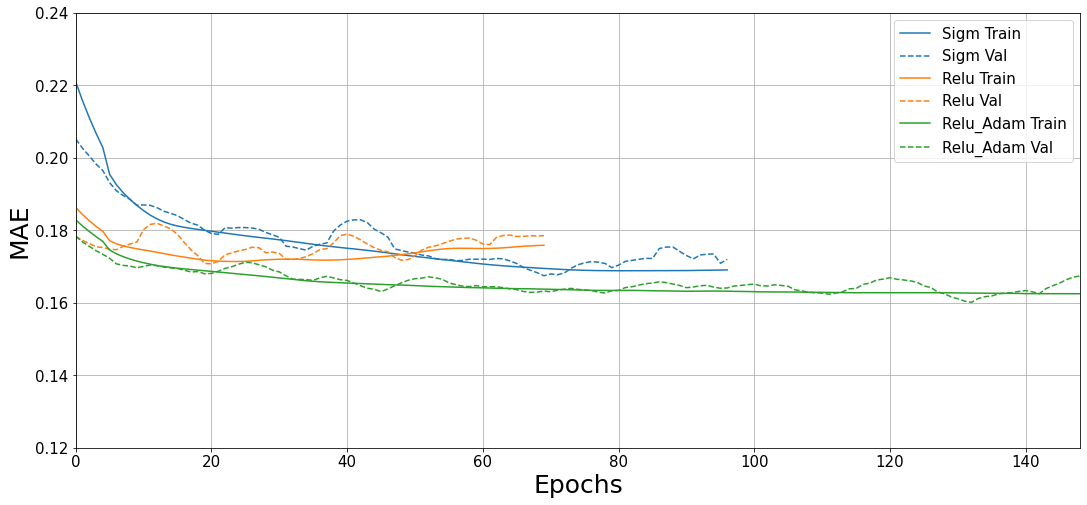

In [49]:
histories['ReLU_Adam'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.12, 0.24])
plt.ylabel('MAE')

In [50]:
nsize = 32
activ = "ReLU_Adam"
model5 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history5 = model5.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1193,  mae:0.1933,  mse:0.1193,  val_loss:0.1180,  val_mae:0.1856,  val_mse:0.1180,  
....................................................................................................
Epoch: 100, loss:0.0847,  mae:0.1532,  mse:0.0847,  val_loss:0.0863,  val_mae:0.1529,  val_mse:0.0863,  
............................................................

Text(0, 0.5, 'MAE')

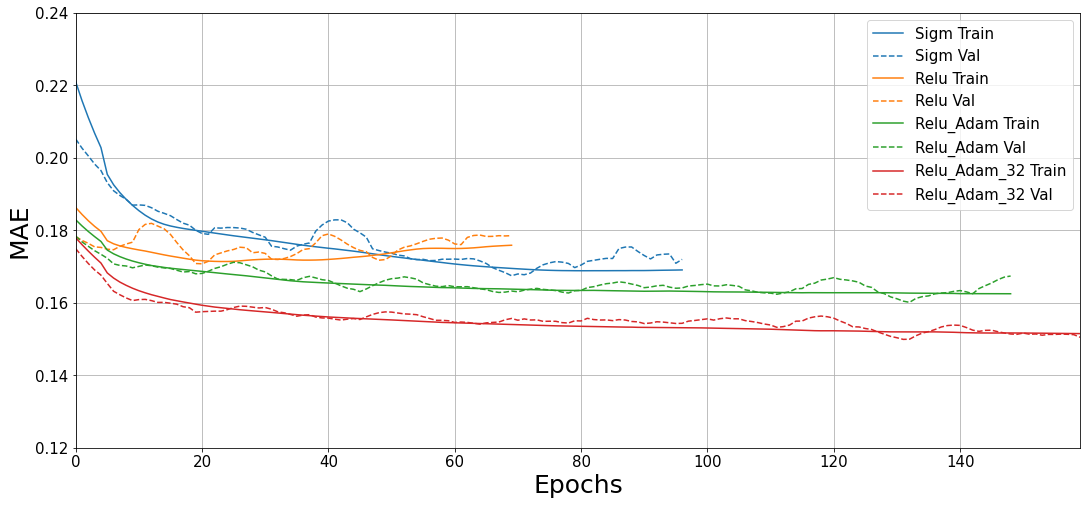

In [51]:
histories['ReLU_Adam_32'] = early_history5

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.12, 0.24])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

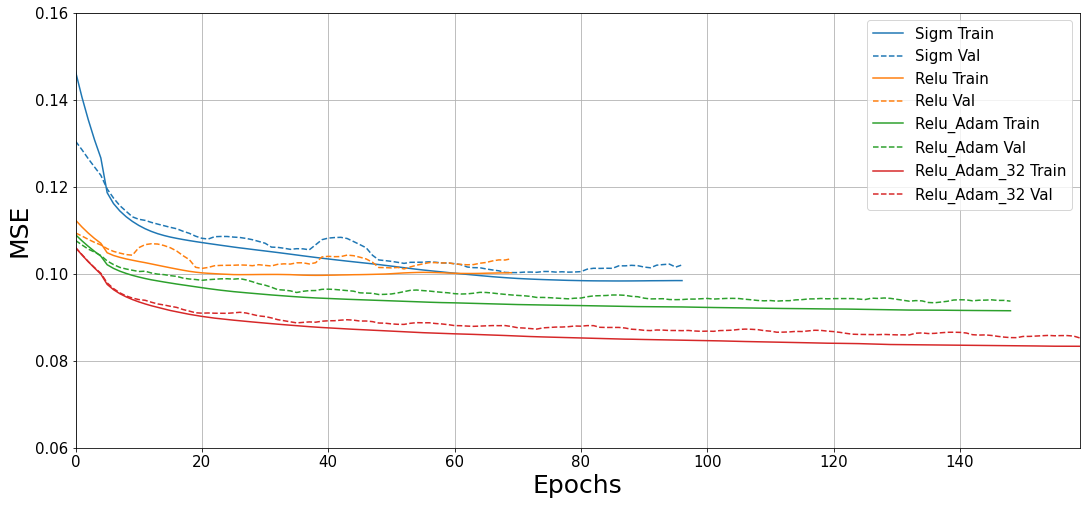

In [55]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mse")
plt.ylim([0.06, 0.16])
plt.ylabel('MSE')

In [56]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

66764/66764 - 2s - loss: 0.0945 - mae: 0.1661 - mse: 0.0945
Testing set for model 2, Mean Abs Error:              0.16607


In [57]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

66764/66764 - 2s - loss: 0.0953 - mae: 0.1677 - mse: 0.0953
Testing set for model 3, Mean Abs Error:              0.16769


In [58]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

66764/66764 - 2s - loss: 0.0882 - mae: 0.1546 - mse: 0.0882
Testing set for model 4, Mean Abs Error:              0.15458


In [59]:
loss5, mae5, mse5 = model5.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 5, Mean Abs Error: {:20.5f}".format(mae5))

66764/66764 - 2s - loss: 0.0816 - mae: 0.1502 - mse: 0.0816
Testing set for model 5, Mean Abs Error:              0.15016


In [60]:
mae = [ mae2, mae3, mae4, mae5 ]
mae

[0.16606511, 0.16768645, 0.15457599, 0.1501589]

In [61]:
mse = [ mse2, mse3, mse4, mse5 ]
mse

[0.09454774, 0.09530818, 0.088169314, 0.0816106]

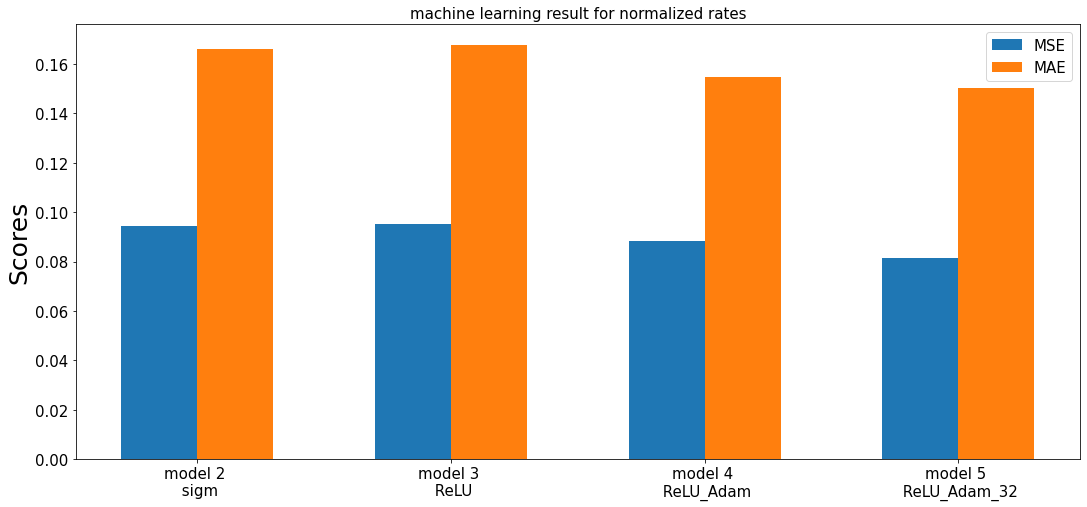

In [62]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = [
 'model 2 \n sigm',
 'model 3 \n ReLU',
 'model 4 \n ReLU_Adam',
 'model 5 \n ReLU_Adam_32' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized rates')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [63]:
test_true_mass = np.exp(test_labels.pop('melt_mass'))

In [64]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [65]:
labels = [ "melt_mass", "melt_num" ]

p1 = pd.DataFrame(data=model2.predict(normed_test_data1), columns=labels)

In [66]:
p1.describe()

melt_mass      melt_num
count  66764.000000  66764.000000
mean      -0.017734     -0.008237
std        0.949465      0.951132
min       -3.130455     -4.295075
25%       -0.631329     -0.582729
50%        0.172110      0.110918
75%        0.754869      0.686263
max        1.796116      2.697804

In [67]:
train_labels_stats

count       mean       std        min        25%        50%  \
melt_mass  311931.0 -14.939188  3.656033 -37.668316 -17.025373 -14.180591   
melt_num   311931.0  -2.079586  3.533464 -31.194771  -3.907827  -1.598078   

                 75%       max  
melt_mass -12.111075 -8.190991  
melt_num    0.363455  7.259201

In [68]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [69]:
test_predict1.describe()

melt_mass      melt_num
count  6.676400e+04  6.676400e+04
mean   5.352893e-06  3.663841e+00
std    1.205433e-05  2.275934e+01
min    3.479135e-12  3.204643e-08
25%    3.232753e-08  1.594455e-02
50%    6.099148e-07  1.849518e-01
75%    5.135345e-06  1.412413e+00
max    2.311307e-04  1.725042e+03

In [70]:
np.exp(test_dataset1.head())

q_g      num_g        rime_g        rvol_g     liq_g  temp
139  8.900105e-07   3.843800  1.941500e-07  4.299696e-10  2.165336   inf
147  4.030701e-07   1.140600  5.262399e-08  1.099900e-10  2.372736   inf
157  9.718603e-08   0.187500  1.509301e-10  2.890703e-13  2.713894   inf
292  7.554700e-06  17.561998  2.480399e-06  4.922103e-09  1.932719   inf
439  9.555297e-07   1.968800  3.084901e-07  4.870903e-10  1.938644   inf

In [71]:
test_predict1.head()

melt_mass  melt_num
0  2.862130e-08  0.170052
1  3.786340e-08  0.117164
2  1.171433e-08  0.044455
3  7.295800e-08  0.400247
4  1.759576e-08  0.066498

In [72]:
test_dataset2.head()

q_g     num_g     rime_g     rvol_g     liq_g        temp
139 -13.932033  1.346462 -15.454635 -21.567307  0.772576  274.309998
147 -14.724155  0.131554 -16.760094 -22.930632  0.864043  274.579987
157 -16.146639 -1.673976 -22.614204 -28.872107  0.998384  274.980011
292 -11.793341  2.865737 -12.907091 -19.129530  0.658928  274.570007
439 -13.861000  0.677424 -14.991576 -21.442572  0.661989  274.670013

In [73]:
test_predict1_mass = test_predict1['melt_mass']

In [74]:

p2 = pd.DataFrame(data=model3.predict(normed_test_data2), columns=labels)

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_mass = test_predict2['melt_mass']

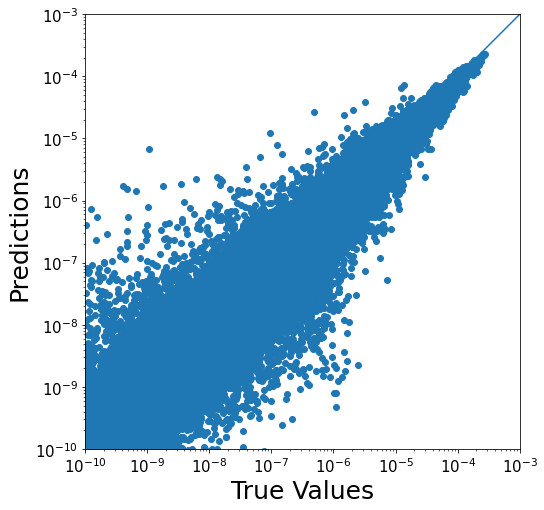

In [75]:
amin, amax = 1e-10, 1e-3

a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict1_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

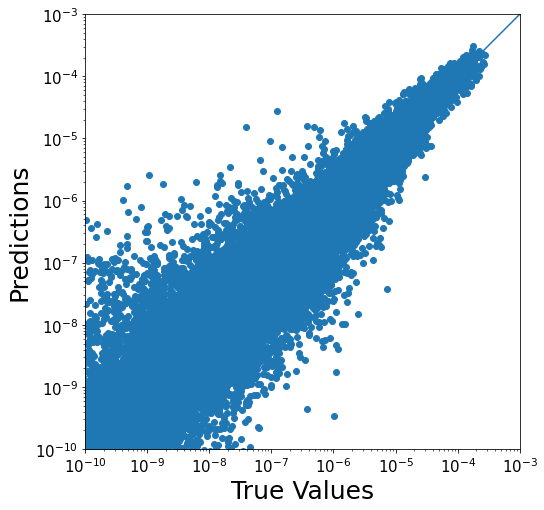

In [76]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict2_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [77]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [78]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [79]:
labels   = 'melt_mass, melt_num'

In [80]:
features = 'q_graupel, n_graupel, rmass_graupel, rvol_graupel, liqfrac, T'
filename = 'saved_model_v2/melt_graupel_rain_model2_'+version+'.nc'
logtransform = np.array([True, True, True, True, False, False], dtype=bool)
save2netcdf(model2,features,labels,train_stats2,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/melt_graupel_rain_model2_12.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel, liqfrac, T
  Labels:     melt_mass, melt_num
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: sigmoid
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 2), Activation: linear


In [81]:
filename = 'saved_model_v2/melt_graupel_rain_model3_'+version+'.nc'
save2netcdf(model3,features,labels,train_stats2,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/melt_graupel_rain_model3_12.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel, liqfrac, T
  Labels:     melt_mass, melt_num
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 2), Activation: linear


In [82]:
filename = 'saved_model_v2/melt_graupel_rain_model4_'+version+'.nc'
save2netcdf(model4,features,labels,train_stats2,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/melt_graupel_rain_model4_12.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel, liqfrac, T
  Labels:     melt_mass, melt_num
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 2), Activation: linear


In [83]:
filename = 'saved_model_v2/melt_graupel_rain_model5_'+version+'.nc'
save2netcdf(model4,features,labels,train_stats2,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/melt_graupel_rain_model5_12.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel, liqfrac, T
  Labels:     melt_mass, melt_num
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 2), Activation: linear
